In [ ]:
import os
import torch
import numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T

torch.manual_seed(2025)

class CustomDataset(Dataset):
    def __init__(self, root, transformations=None, im_files=(".png", ".jpg", ".jpeg")):
        self.transformations = transformations
        all_files = glob(os.path.join(root, "*", "*"))
        self.im_paths = [f for f in all_files if f.endswith(im_files)]
        print(f"[DEBUG] Found {len(self.im_paths)} total images")

        self.cls_names, self.cls_counts = {}, {}
        count = 0
        for im_path in self.im_paths:
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

    def get_class(self, path):
        return os.path.dirname(path).split("/")[-1]

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None:
            im = self.transformations(im)

        return im, gt

    @classmethod
    def get_dls(cls, root, transformations, bs, ns=0):
        full_ds = cls(root=root, transformations=transformations)
        cls_names, cls_counts = full_ds.cls_names, full_ds.cls_counts

        total_len = len(full_ds)
        test_len = int(total_len * 0.2)
        train_val_len = total_len - test_len

        train_val_ds, test_ds = random_split(full_ds, [train_val_len, test_len])

        train_len = int(train_val_len * 0.8)
        val_len = train_val_len - train_len

        train_ds, val_ds = random_split(train_val_ds, [train_len, val_len])

        train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=ns)
        val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=ns)
        test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=ns)

        return train_dl, val_dl, test_dl, cls_names, cls_counts

from google.colab import drive
drive.mount('/content/drive')

root = "/content/drive/MyDrive/Datasets/Parkinson's MRI"

mean, std, im_size, bs = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224, 32
tfs = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

tr_dl, val_dl, ts_dl, classes, cls_counts = CustomDataset.get_dls(root=root, transformations=tfs, bs=bs)

print(f"\nTrain Batches: {len(tr_dl)}")
print(f"Validation Batches: {len(val_dl)}")
print(f"Test Batches: {len(ts_dl)}")
print(f"Classes: {classes}")
print(f"Class Counts: {cls_counts}")

Mounted at /content/drive
[DEBUG] Found 1220 total images

Train Batches: 25
Validation Batches: 7
Test Batches: 244
Classes: {'parkinson': 0, 'normal': 1}
Class Counts: {'parkinson': 610, 'normal': 610}


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.data = datasets.ImageFolder(root=root, transform=self.transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @staticmethod
    def get_dls(root, transformations, bs):
        full_ds = CustomDataset(root=root, transform=transformations)

        total_len = len(full_ds)
        test_len = int(total_len * 0.2)
        train_val_len = total_len - test_len

        train_val_ds, test_ds = random_split(full_ds, [train_val_len, test_len])

        train_len = int(train_val_len * 0.8)
        val_len = train_val_len - train_len
        train_ds, val_ds = random_split(train_val_ds, [train_len, val_len])

        train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False)
        test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False)

        classes = full_ds.data.classes
        cls_counts = {cls: 0 for cls in classes}
        for _, label in full_ds:
            cls_counts[classes[label]] += 1

        return train_dl, val_dl, test_dl, classes, cls_counts

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class distribution: {'normal': 610, 'parkinson': 610}

Visualizing Train Dataset...



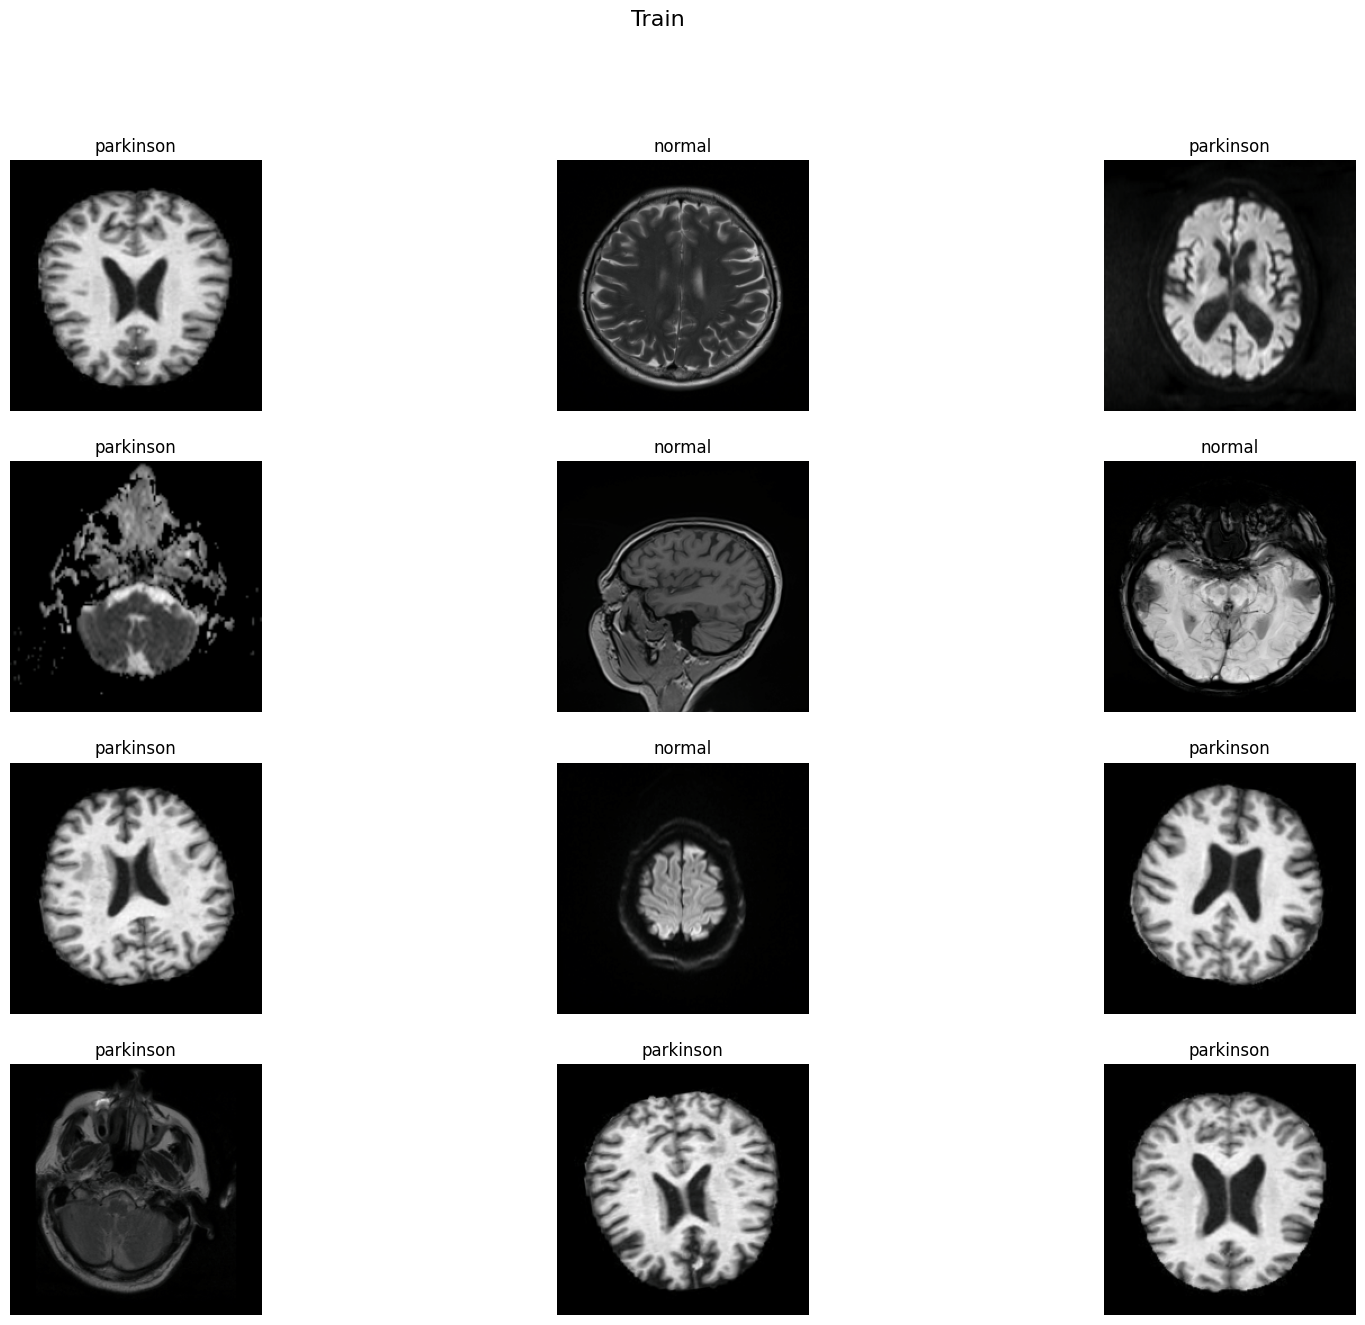


Visualizing Validation Dataset...



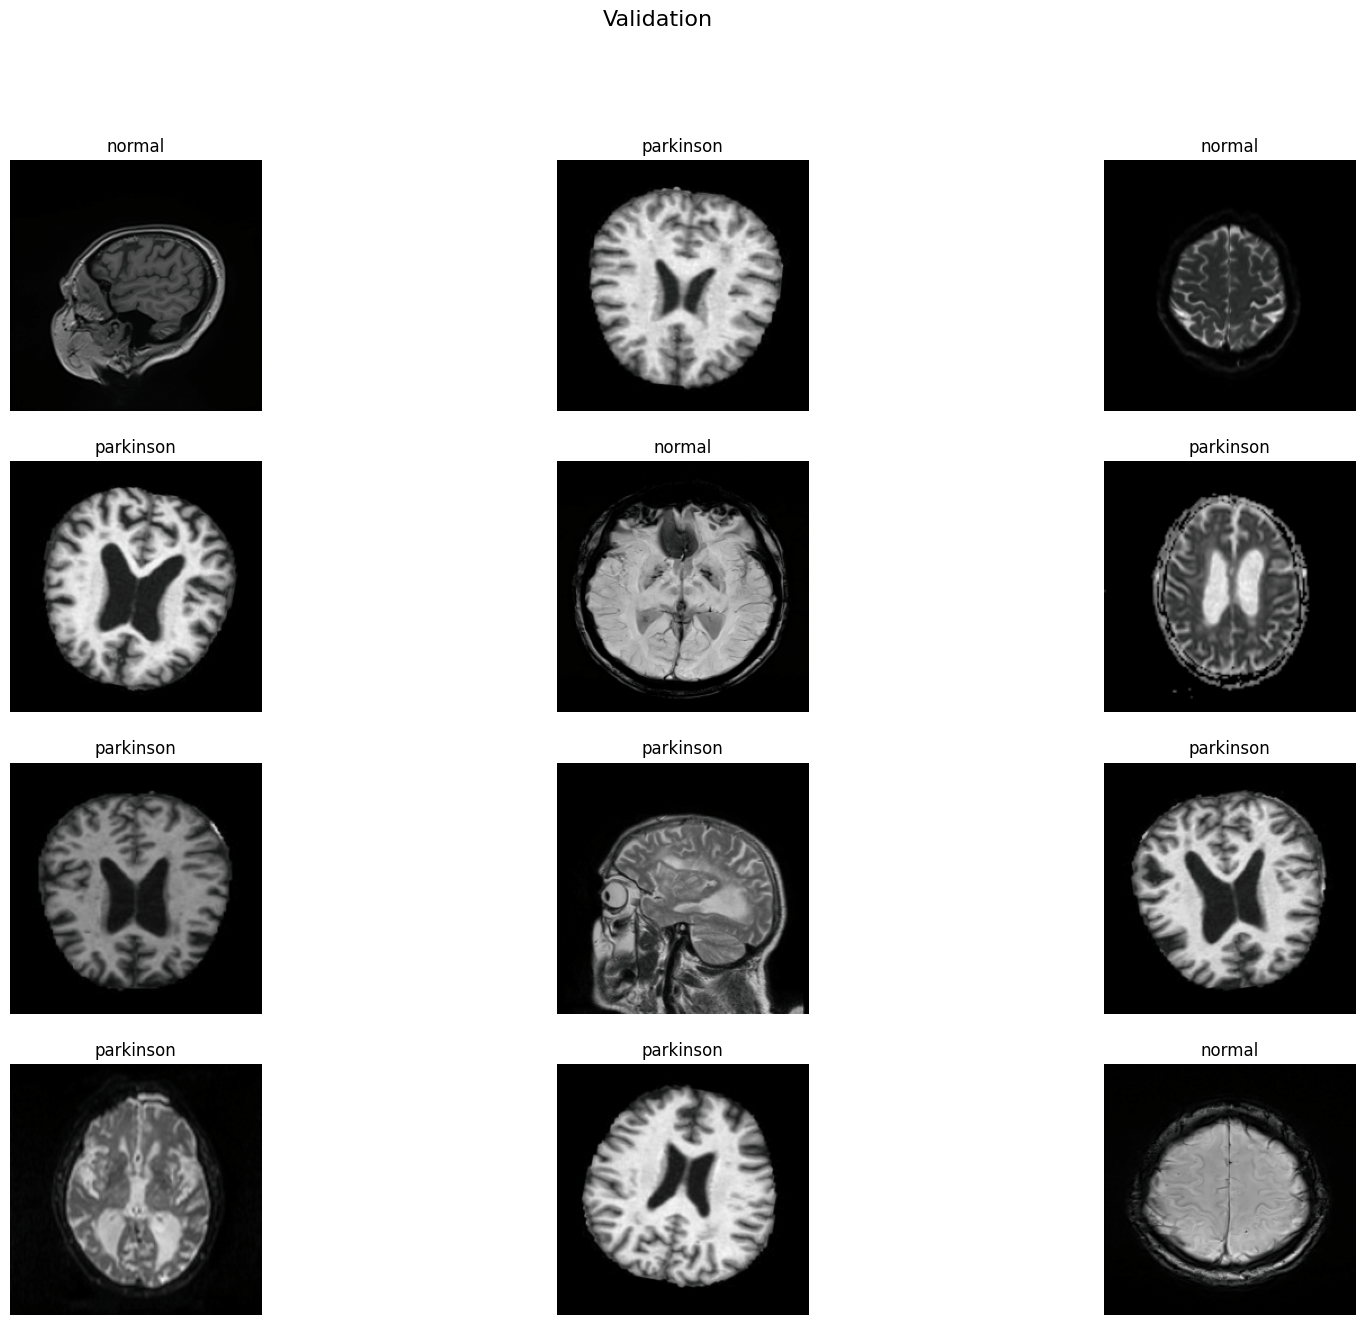


Visualizing Test Dataset...



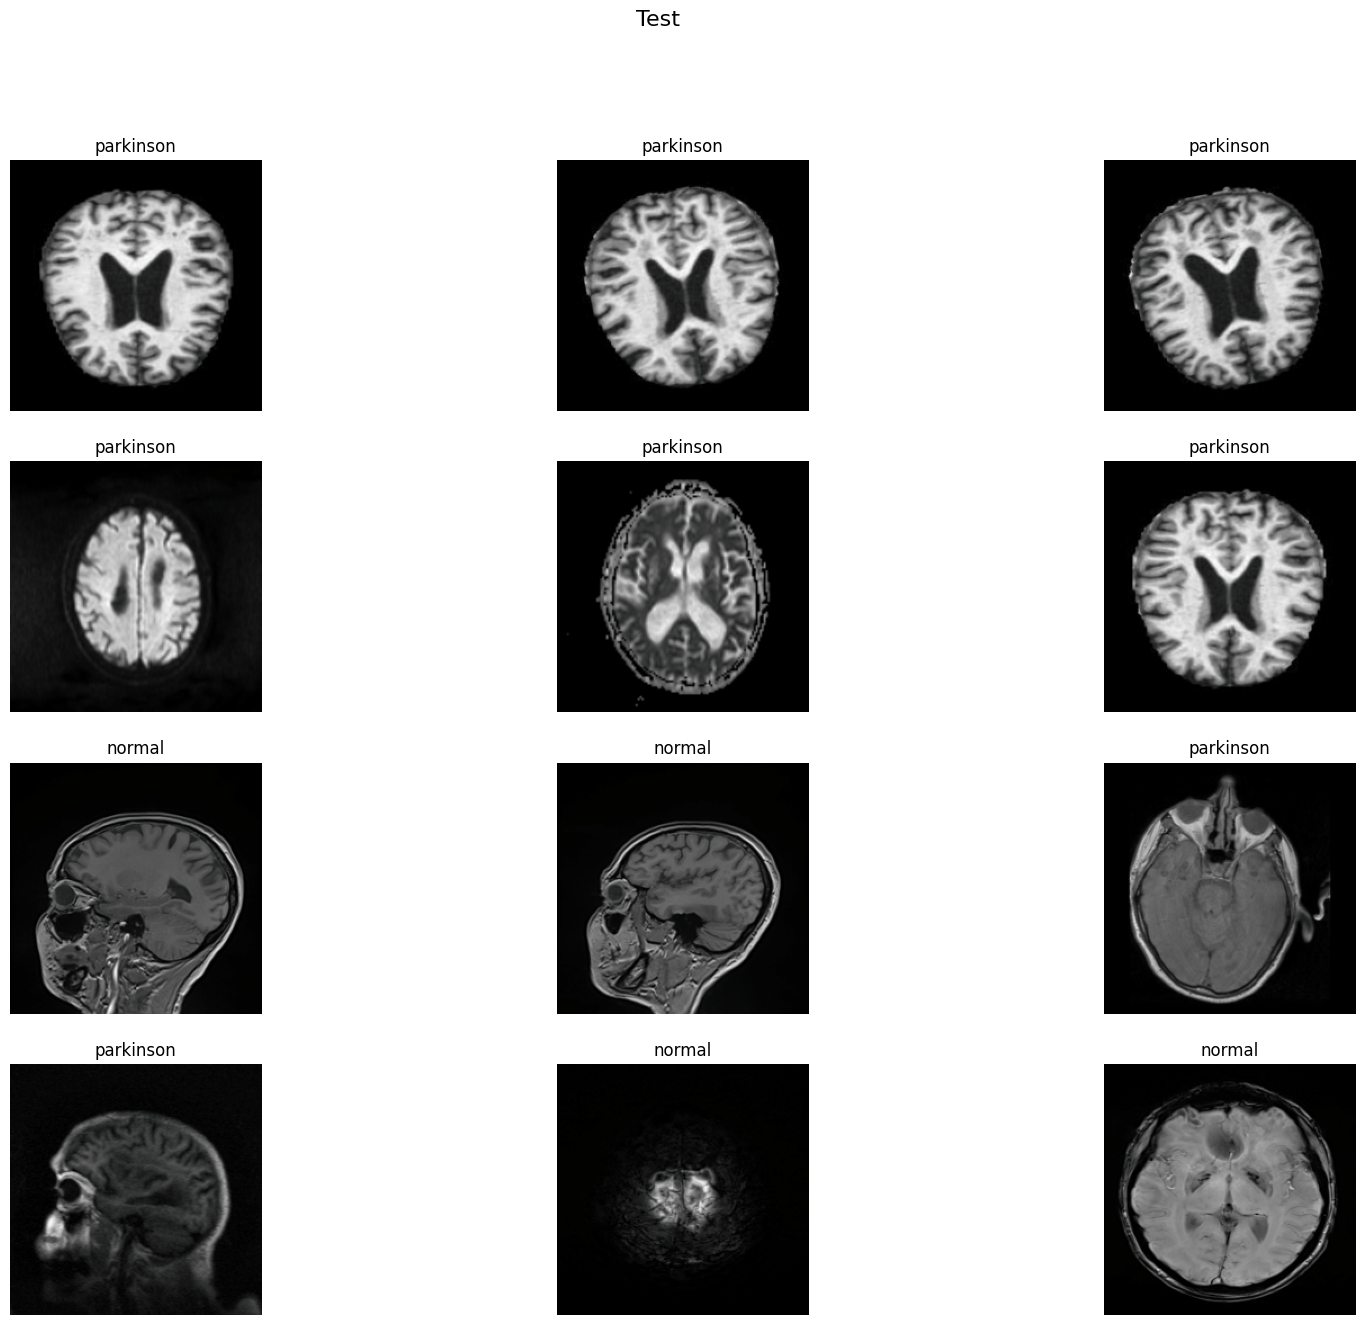


Generating Bar Chart...


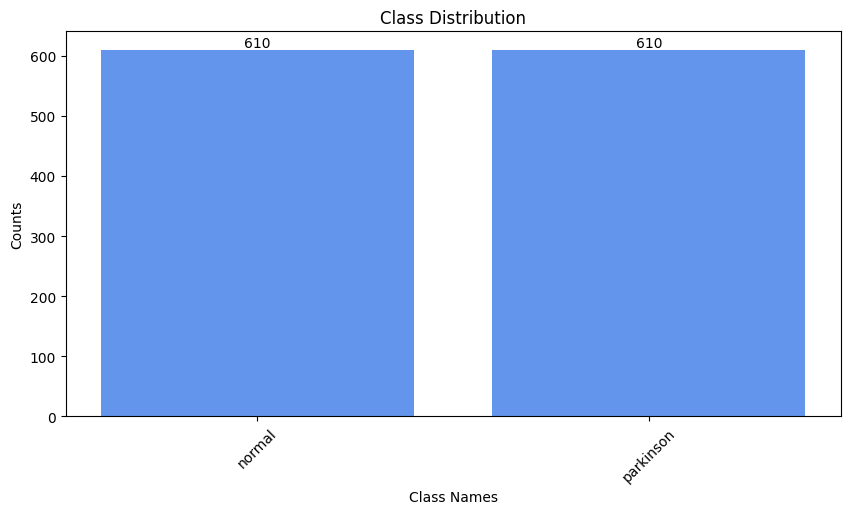


Generating Pie Chart...


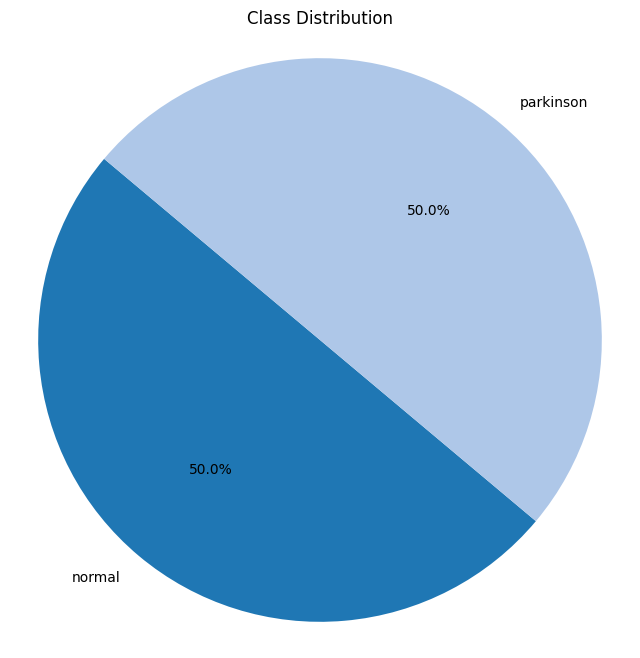

In [ ]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

root = "/content/drive/MyDrive/Datasets/Parkinson's MRI"

mean, std, im_size, bs = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224, 32
tfs = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

full_ds = datasets.ImageFolder(root=root, transform=tfs)
classes = full_ds.classes

total_len = len(full_ds)
test_len = int(total_len * 0.2)
train_val_len = total_len - test_len
train_val_ds, test_ds = random_split(full_ds, [train_val_len, test_len])

train_len = int(train_val_len * 0.8)
val_len = train_val_len - train_len
train_ds, val_ds = random_split(train_val_ds, [train_len, val_len])

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=2)

cls_counts = {cls: 0 for cls in classes}
for _, label in full_ds:
    cls_counts[classes[label]] += 1
print("Class distribution:", cls_counts)

class Visualization:
    def __init__(self, classes, cls_counts, n_ims=12, rows=4):
        self.classes = classes
        self.cls_counts = cls_counts
        self.n_ims = n_ims
        self.rows = rows

    def tn2np(self, t):
        invTrans = transforms.Compose([
            transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
            transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
        ])
        return (invTrans(t).detach().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    def visualize_samples(self, data_loader, title):
        print(f"\nVisualizing {title} Dataset...\n")
        cols = self.n_ims // self.rows
        plt.figure(figsize=(20, 15))

        images, labels = next(iter(data_loader))
        images, labels = images[:self.n_ims], labels[:self.n_ims]

        for idx in range(min(len(images), self.rows * cols)):
            plt.subplot(self.rows, cols, idx + 1)
            plt.imshow(self.tn2np(images[idx]))
            plt.axis('off')
            plt.title(f"{self.classes[int(labels[idx])]}")

        plt.suptitle(title, fontsize=16)
        plt.show()

    def plot_bar_chart(self):
        print("\nGenerating Bar Chart...")
        cls_names = list(self.cls_counts.keys())
        counts = list(self.cls_counts.values())

        plt.figure(figsize=(10, 5))
        plt.bar(cls_names, counts, color="cornflowerblue")
        plt.xlabel("Class Names")
        plt.ylabel("Counts")
        plt.xticks(rotation=45)
        plt.title("Class Distribution")

        for i, v in enumerate(counts):
            plt.text(i, v + 5, str(v), ha="center")

        plt.show()

    def plot_pie_chart(self):
        print("\nGenerating Pie Chart...")
        labels = list(self.cls_counts.keys())
        sizes = list(self.cls_counts.values())

        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
        plt.title("Class Distribution")
        plt.axis("equal")
        plt.show()

vis = Visualization(classes, cls_counts)
vis.visualize_samples(train_dl, "Train")
vis.visualize_samples(val_dl, "Validation")
vis.visualize_samples(test_dl, "Test")
vis.plot_bar_chart()
vis.plot_pie_chart()

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]


Epoch 1/100


Training: 100%|██████████| 49/49 [01:32<00:00,  1.88s/it]


Train Loss: 0.3271, Acc: 0.9231, F1: 0.9231


Validation: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]


Val Loss: 0.3036, Acc: 0.9286, F1: 0.9286
✅ Saved model using joblib with accuracy: 0.9286

Epoch 2/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.24it/s]


Train Loss: 0.2229, Acc: 0.9962, F1: 0.9962


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.23it/s]


Val Loss: 0.3478, Acc: 0.9082, F1: 0.9082

Epoch 3/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.09it/s]


Train Loss: 0.2220, Acc: 0.9962, F1: 0.9962


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.14it/s]


Val Loss: 0.2205, Acc: 0.9949, F1: 0.9949
✅ Saved model using joblib with accuracy: 0.9949

Epoch 4/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.62it/s]


Train Loss: 0.2115, Acc: 0.9987, F1: 0.9987


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.47it/s]


Val Loss: 0.2318, Acc: 1.0000, F1: 1.0000
✅ Saved model using joblib with accuracy: 1.0000

Epoch 5/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.32it/s]


Train Loss: 0.2066, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]


Val Loss: 0.2027, Acc: 1.0000, F1: 1.0000

Epoch 6/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.21it/s]


Train Loss: 0.2035, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.52it/s]


Val Loss: 0.2015, Acc: 1.0000, F1: 1.0000

Epoch 7/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.99it/s]


Train Loss: 0.2021, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


Val Loss: 0.2006, Acc: 1.0000, F1: 1.0000

Epoch 8/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.58it/s]


Train Loss: 0.2015, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.52it/s]


Val Loss: 0.2013, Acc: 1.0000, F1: 1.0000

Epoch 9/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.73it/s]


Train Loss: 0.2030, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  9.05it/s]


Val Loss: 0.2005, Acc: 1.0000, F1: 1.0000

Epoch 10/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.48it/s]


Train Loss: 0.2004, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.30it/s]


Val Loss: 0.2014, Acc: 1.0000, F1: 1.0000

Epoch 11/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.24it/s]


Train Loss: 0.1999, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.47it/s]


Val Loss: 0.2000, Acc: 1.0000, F1: 1.0000

Epoch 12/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.25it/s]


Train Loss: 0.1996, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.59it/s]


Val Loss: 0.2023, Acc: 0.9949, F1: 0.9949

Epoch 13/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.37it/s]


Train Loss: 0.1998, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.53it/s]


Val Loss: 0.1992, Acc: 1.0000, F1: 1.0000

Epoch 14/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.38it/s]


Train Loss: 0.1993, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.25it/s]


Val Loss: 0.1995, Acc: 1.0000, F1: 1.0000

Epoch 15/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.37it/s]


Train Loss: 0.1998, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  9.57it/s]


Val Loss: 0.1994, Acc: 1.0000, F1: 1.0000

Epoch 16/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.51it/s]


Train Loss: 0.2004, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.42it/s]


Val Loss: 0.2034, Acc: 1.0000, F1: 1.0000

Epoch 17/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.39it/s]


Train Loss: 0.1998, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.11it/s]


Val Loss: 0.2005, Acc: 1.0000, F1: 1.0000

Epoch 18/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.19it/s]


Train Loss: 0.1992, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.38it/s]


Val Loss: 0.1991, Acc: 1.0000, F1: 1.0000

Epoch 19/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.46it/s]


Train Loss: 0.2002, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.29it/s]


Val Loss: 0.1999, Acc: 1.0000, F1: 1.0000

Epoch 20/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.10it/s]


Train Loss: 0.1994, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.57it/s]


Val Loss: 0.1991, Acc: 1.0000, F1: 1.0000

Epoch 21/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.69it/s]


Train Loss: 0.1990, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.25it/s]


Val Loss: 0.1991, Acc: 1.0000, F1: 1.0000

Epoch 22/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.20it/s]


Train Loss: 0.1989, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]


Val Loss: 0.1992, Acc: 1.0000, F1: 1.0000

Epoch 23/100


Training: 100%|██████████| 49/49 [00:05<00:00,  8.72it/s]


Train Loss: 0.1989, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.46it/s]


Val Loss: 0.1990, Acc: 1.0000, F1: 1.0000

Epoch 24/100


Training: 100%|██████████| 49/49 [00:05<00:00,  8.37it/s]


Train Loss: 0.1988, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:02<00:00,  6.06it/s]


Val Loss: 0.1993, Acc: 1.0000, F1: 1.0000

Epoch 25/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.32it/s]


Train Loss: 0.1992, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.28it/s]


Val Loss: 0.2000, Acc: 1.0000, F1: 1.0000

Epoch 26/100


Training: 100%|██████████| 49/49 [00:06<00:00,  8.03it/s]


Train Loss: 0.1989, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.76it/s]


Val Loss: 0.1999, Acc: 1.0000, F1: 1.0000

Epoch 27/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.33it/s]


Train Loss: 0.1988, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.37it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 28/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.55it/s]


Train Loss: 0.1990, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  9.14it/s]


Val Loss: 0.2000, Acc: 1.0000, F1: 1.0000

Epoch 29/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.50it/s]


Train Loss: 0.1988, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.45it/s]


Val Loss: 0.1996, Acc: 1.0000, F1: 1.0000

Epoch 30/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.49it/s]


Train Loss: 0.1988, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.48it/s]


Val Loss: 0.1989, Acc: 1.0000, F1: 1.0000

Epoch 31/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.46it/s]


Train Loss: 0.1989, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.36it/s]


Val Loss: 0.1991, Acc: 1.0000, F1: 1.0000

Epoch 32/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.40it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.15it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 33/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.41it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.64it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 34/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.43it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.30it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 35/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.45it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.31it/s]


Val Loss: 0.1992, Acc: 1.0000, F1: 1.0000

Epoch 36/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.42it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 37/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.43it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.40it/s]


Val Loss: 0.2028, Acc: 1.0000, F1: 1.0000

Epoch 38/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.52it/s]


Train Loss: 0.1988, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.36it/s]


Val Loss: 0.1991, Acc: 1.0000, F1: 1.0000

Epoch 39/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.58it/s]


Train Loss: 0.1988, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.46it/s]


Val Loss: 0.1992, Acc: 1.0000, F1: 1.0000

Epoch 40/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.45it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.49it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 41/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.31it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  8.26it/s]


Val Loss: 0.1990, Acc: 1.0000, F1: 1.0000

Epoch 42/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.87it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.48it/s]


Val Loss: 0.1989, Acc: 1.0000, F1: 1.0000

Epoch 43/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.46it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 44/100


Training: 100%|██████████| 49/49 [00:05<00:00,  8.28it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.39it/s]


Val Loss: 0.1986, Acc: 1.0000, F1: 1.0000

Epoch 45/100


Training: 100%|██████████| 49/49 [00:05<00:00,  8.55it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 46/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.26it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.55it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 47/100


Training: 100%|██████████| 49/49 [00:05<00:00,  8.36it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.86it/s]


Val Loss: 0.1989, Acc: 1.0000, F1: 1.0000

Epoch 48/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.59it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  9.48it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 49/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.95it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 50/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.52it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.59it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 51/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.72it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  9.76it/s]


Val Loss: 0.1994, Acc: 1.0000, F1: 1.0000

Epoch 52/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.61it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.26it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 53/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.52it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.07it/s]


Val Loss: 0.1994, Acc: 1.0000, F1: 1.0000

Epoch 54/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.54it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.33it/s]


Val Loss: 0.2000, Acc: 1.0000, F1: 1.0000

Epoch 55/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.49it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.27it/s]


Val Loss: 0.1992, Acc: 1.0000, F1: 1.0000

Epoch 56/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.42it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.48it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 57/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.56it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.29it/s]


Val Loss: 0.2000, Acc: 1.0000, F1: 1.0000

Epoch 58/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.23it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.32it/s]


Val Loss: 0.1990, Acc: 1.0000, F1: 1.0000

Epoch 59/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.23it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.34it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 60/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.49it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  9.43it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 61/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.28it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.23it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 62/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.31it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.38it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 63/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.35it/s]


Train Loss: 0.1987, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.17it/s]


Val Loss: 0.1995, Acc: 1.0000, F1: 1.0000

Epoch 64/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.41it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.96it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 65/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.81it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.56it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 66/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.13it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:02<00:00,  6.26it/s]


Val Loss: 0.1986, Acc: 1.0000, F1: 1.0000

Epoch 67/100


Training: 100%|██████████| 49/49 [00:05<00:00,  8.57it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.68it/s]


Val Loss: 0.1993, Acc: 1.0000, F1: 1.0000

Epoch 68/100


Training: 100%|██████████| 49/49 [00:05<00:00,  8.61it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:02<00:00,  6.21it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 69/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.07it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.37it/s]


Val Loss: 0.1986, Acc: 1.0000, F1: 1.0000

Epoch 70/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.86it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 71/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.47it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.34it/s]


Val Loss: 0.1990, Acc: 1.0000, F1: 1.0000

Epoch 72/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.69it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  9.38it/s]


Val Loss: 0.1990, Acc: 1.0000, F1: 1.0000

Epoch 73/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.33it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.40it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 74/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.38it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.52it/s]


Val Loss: 0.1989, Acc: 1.0000, F1: 1.0000

Epoch 75/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.53it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.37it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 76/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.54it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.46it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 77/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.48it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.50it/s]


Val Loss: 0.1990, Acc: 1.0000, F1: 1.0000

Epoch 78/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.45it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  9.96it/s]


Val Loss: 0.1986, Acc: 1.0000, F1: 1.0000

Epoch 79/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.55it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.29it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 80/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.49it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.57it/s]


Val Loss: 0.1993, Acc: 1.0000, F1: 1.0000

Epoch 81/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.61it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.43it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 82/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.42it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.05it/s]


Val Loss: 0.1993, Acc: 1.0000, F1: 1.0000

Epoch 83/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.18it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.54it/s]


Val Loss: 0.1986, Acc: 1.0000, F1: 1.0000

Epoch 84/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.44it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.37it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 85/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.19it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val Loss: 0.2000, Acc: 1.0000, F1: 1.0000

Epoch 86/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.82it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.55it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 87/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.38it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 88/100


Training: 100%|██████████| 49/49 [00:05<00:00,  8.17it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.33it/s]


Val Loss: 0.1993, Acc: 1.0000, F1: 1.0000

Epoch 89/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.48it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 90/100


Training: 100%|██████████| 49/49 [00:05<00:00,  8.42it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.44it/s]


Val Loss: 0.1990, Acc: 1.0000, F1: 1.0000

Epoch 91/100


Training: 100%|██████████| 49/49 [00:05<00:00,  8.87it/s]


Train Loss: 0.1989, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 92/100


Training: 100%|██████████| 49/49 [00:05<00:00,  8.97it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.35it/s]


Val Loss: 0.1989, Acc: 1.0000, F1: 1.0000

Epoch 93/100


Training: 100%|██████████| 49/49 [00:05<00:00,  8.46it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]


Val Loss: 0.1990, Acc: 1.0000, F1: 1.0000

Epoch 94/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.48it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.45it/s]


Val Loss: 0.1989, Acc: 1.0000, F1: 1.0000

Epoch 95/100


Training: 100%|██████████| 49/49 [00:06<00:00,  8.08it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.25it/s]


Val Loss: 0.1987, Acc: 1.0000, F1: 1.0000

Epoch 96/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.57it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.44it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 97/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.52it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00,  9.35it/s]


Val Loss: 0.1988, Acc: 1.0000, F1: 1.0000

Epoch 98/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.42it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.34it/s]


Val Loss: 0.2011, Acc: 0.9949, F1: 0.9949

Epoch 99/100


Training: 100%|██████████| 49/49 [00:06<00:00,  7.48it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.32it/s]


Val Loss: 0.2001, Acc: 1.0000, F1: 1.0000

Epoch 100/100


Training: 100%|██████████| 49/49 [00:05<00:00,  9.29it/s]


Train Loss: 0.1986, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 13/13 [00:01<00:00, 10.37it/s]


Val Loss: 0.1993, Acc: 1.0000, F1: 1.0000


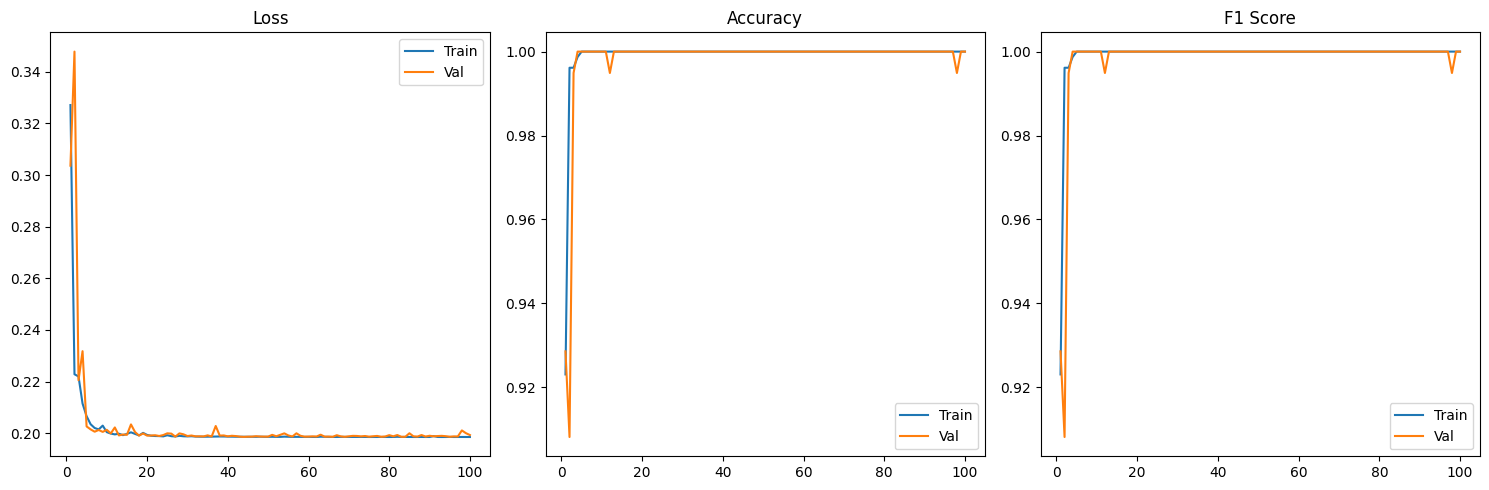


Overfitting Check:
Epoch 1: No significant overfitting detected.
Epoch 2: No significant overfitting detected.
Epoch 3: No significant overfitting detected.
Epoch 4: No significant overfitting detected.
Epoch 5: No significant overfitting detected.
Epoch 6: No significant overfitting detected.
Epoch 7: No significant overfitting detected.
Epoch 8: No significant overfitting detected.
Epoch 9: No significant overfitting detected.
Epoch 10: No significant overfitting detected.
Epoch 11: No significant overfitting detected.
Epoch 12: No significant overfitting detected.
Epoch 13: No significant overfitting detected.
Epoch 14: No significant overfitting detected.
Epoch 15: No significant overfitting detected.
Epoch 16: No significant overfitting detected.
Epoch 17: No significant overfitting detected.
Epoch 18: No significant overfitting detected.
Epoch 19: No significant overfitting detected.
Epoch 20: No significant overfitting detected.
Epoch 21: No significant overfitting detected.
Ep

In [ ]:
!pip install timm torchmetrics torchvision tqdm matplotlib --quiet

import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import joblib

from google.colab import drive
drive.mount('/content/drive')

# Paths
ROOT_DIR = "/content/drive/MyDrive/Datasets/Parkinson's MRI"
SAVE_DIR = "/content/drive/MyDrive/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Image Transformations
mean, std = [0.5]*3, [0.5]*3
img_size = 224
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Dataset & Loaders
full_dataset = datasets.ImageFolder(root=ROOT_DIR, transform=transform)
classes = full_dataset.classes

test_size = int(0.2 * len(full_dataset))
train_val_size = len(full_dataset) - test_size
train_val_dataset, test_dataset = random_split(full_dataset, [train_val_size, test_size], generator=torch.Generator().manual_seed(42))

train_size = int(0.8 * train_val_size)
val_size = train_val_size - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Trainer Class
class Trainer:
    def __init__(self, model_name, classes, train_loader, val_loader, device, save_dir, lr=1e-3, epochs=50):
        self.device = device
        self.model = timm.create_model(model_name, pretrained=True, num_classes=len(classes)).to(device)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=epochs)
        self.f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(device)

        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.save_dir = save_dir
        self.best_acc = 0.0

        self.train_losses, self.val_losses = [], []
        self.train_accs, self.val_accs = [], []
        self.train_f1s, self.val_f1s = [], []

    @staticmethod
    def to_device(batch, device):
        return batch[0].to(device), batch[1].to(device)

    def train_epoch(self):
        self.model.train()
        total_loss, correct, total = 0.0, 0, 0
        self.f1_metric.reset()

        for batch in tqdm(self.train_loader, desc="Training"):
            images, labels = self.to_device(batch, self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
            self.f1_metric.update(outputs, labels)

        acc = correct / total
        f1 = self.f1_metric.compute().item()
        self.train_losses.append(total_loss / len(self.train_loader))
        self.train_accs.append(acc)
        self.train_f1s.append(f1)
        return self.train_losses[-1], acc, f1

    def validate(self):
        self.model.eval()
        total_loss, correct, total = 0.0, 0, 0
        self.f1_metric.reset()

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation"):
                images, labels = self.to_device(batch, self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)
                self.f1_metric.update(outputs, labels)

        acc = correct / total
        f1 = self.f1_metric.compute().item()
        self.val_losses.append(total_loss / len(self.val_loader))
        self.val_accs.append(acc)
        self.val_f1s.append(f1)
        return self.val_losses[-1], acc, f1

    def save_model(self, val_acc):
        path = os.path.join(self.save_dir, "best_model.pkl")
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            joblib.dump(self.model, path, protocol=4)  # ✅ Save using protocol=4
            print(f"✅ Saved model using joblib with accuracy: {val_acc:.4f}")

    def plot_metrics(self):
        epochs = range(1, self.epochs + 1)
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.train_losses, label='Train')
        plt.plot(epochs, self.val_losses, label='Val')
        plt.title("Loss")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.train_accs, label='Train')
        plt.plot(epochs, self.val_accs, label='Val')
        plt.title("Accuracy")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.train_f1s, label='Train')
        plt.plot(epochs, self.val_f1s, label='Val')
        plt.title("F1 Score")
        plt.legend()

        plt.tight_layout()
        plt.show()

    def check_overfitting(self):
        print("\nOverfitting Check:")
        for i in range(self.epochs):
            loss_diff = self.val_losses[i] - self.train_losses[i]
            acc_diff = self.train_accs[i] - self.val_accs[i]
            if loss_diff > 0.2 and acc_diff > 0.1:
                print(f"Epoch {i+1}: Potential overfitting (Train Acc: {self.train_accs[i]:.2f}, Val Acc: {self.val_accs[i]:.2f})")
            else:
                print(f"Epoch {i+1}: No significant overfitting detected.")

    def run(self):
        for epoch in range(self.epochs):
            print(f"\nEpoch {epoch + 1}/{self.epochs}")
            tr_loss, tr_acc, tr_f1 = self.train_epoch()
            print(f"Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f}, F1: {tr_f1:.4f}")
            val_loss, val_acc, val_f1 = self.validate()
            print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
            self.save_model(val_acc)
            self.scheduler.step()

        self.plot_metrics()
        self.check_overfitting()


# Train
model_name = "resnet18"
device = "cuda" if torch.cuda.is_available() else "cpu"

trainer = Trainer(
    model_name=model_name,
    classes=classes,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    save_dir=SAVE_DIR,
    epochs=100
)

trainer.run()

# Test Evaluation
def evaluate_on_testset(model_path, test_loader, classes, device):
    print("\nEvaluating on Test Set...")
    model = joblib.load(model_path)  # ✅ Load using joblib
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()
    f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(device)

    total_loss, correct, total = 0.0, 0, 0
    f1_metric.reset()

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
            f1_metric.update(outputs, labels)

    acc = correct / total
    f1 = f1_metric.compute().item()
    avg_loss = total_loss / len(test_loader)

    print(f"\nTest Results:\nLoss: {avg_loss:.4f} | Accuracy: {acc*100:.2f}% | F1 Score: {f1:.4f}")



NameError: name 'model' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import joblib
import torch

# Load the MRI model
mri_model = joblib.load("/content/drive/MyDrive/ParkinsonsModels/mri_model.pkl")
print(mri_model)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
     